TODO:

- add the other DBDs from the same clan
- check fraction of TFs with annotated domains
    - e.g. why does ZNF593 not have any domains?
- try alternative randomization based null

In [11]:
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from data_loading import load_annotated_gencode_tfs, load_pfam_clans, load_DNA_binding_domains

tfs = load_annotated_gencode_tfs()
clans = load_pfam_clans()

100%|██████████| 2748/2748 [02:15<00:00, 20.35it/s]


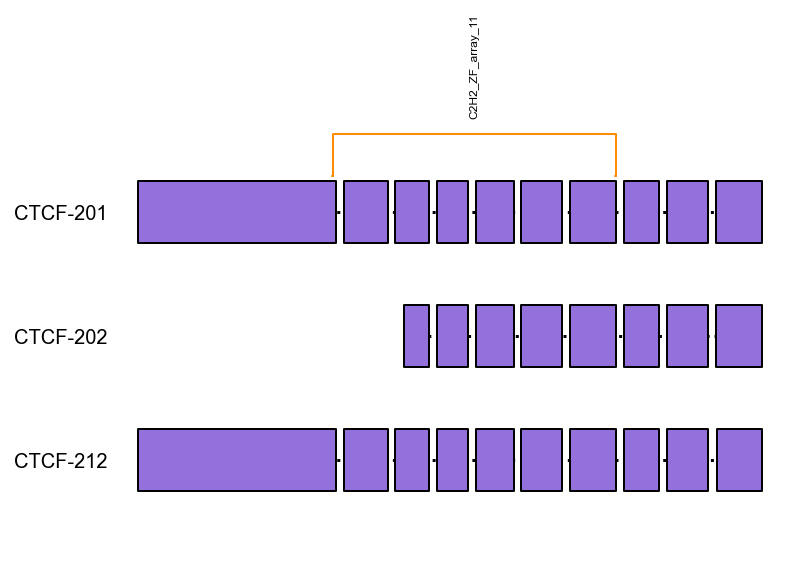

In [2]:
tfs['CTCF'].exon_diagram()

In [43]:
tfs['CTCF'].random_aa_seq_feature_shuffle(ref_iso_name='CTCF-201',
                                          n=10)

,gene,ref_iso,random_sample,alt_iso,accession,deletion,insertion,frameshift,length
0,CTCF,CTCF-201,0,CTCF-202,C2H2_ZF_array_11,0,0,0,311
1,CTCF,CTCF-201,0,CTCF-212,C2H2_ZF_array_11,2,0,0,311
2,CTCF,CTCF-201,1,CTCF-202,C2H2_ZF_array_11,0,0,0,311
3,CTCF,CTCF-201,1,CTCF-212,C2H2_ZF_array_11,0,0,0,311
4,CTCF,CTCF-201,2,CTCF-202,C2H2_ZF_array_11,147,0,0,311
5,CTCF,CTCF-201,2,CTCF-212,C2H2_ZF_array_11,0,0,0,311
6,CTCF,CTCF-201,3,CTCF-202,C2H2_ZF_array_11,185,0,0,311
7,CTCF,CTCF-201,3,CTCF-212,C2H2_ZF_array_11,0,0,0,311
8,CTCF,CTCF-201,4,CTCF-202,C2H2_ZF_array_11,216,0,0,311
9,CTCF,CTCF-201,4,CTCF-212,C2H2_ZF_array_11,0,0,0,311


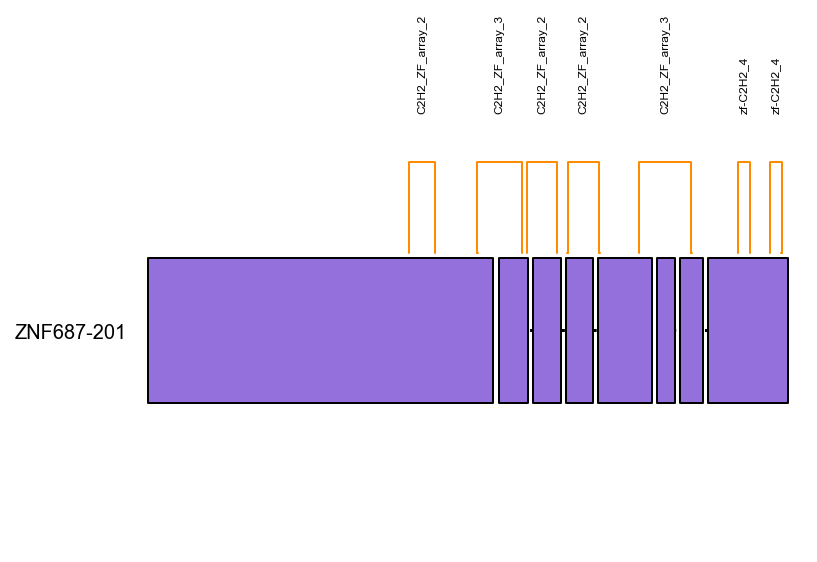

In [3]:
tfs['ZNF687'].exon_diagram()

In [25]:
df = pd.concat([g.aa_feature_disruption(g.orfs[0].name) for g in tfs.values()])
dbd = load_DNA_binding_domains()
dbd['clan'] = dbd['pfam'].map(clans)
dbd['num_genes'] = dbd['pfam'].map(df.groupby('accession')['gene'].size())
df['is_DBD'] = df['accession'].isin(dbd['pfam'].values) | df['accession'].str.startswith('C2H2_ZF_array')
df['is_affected'] = (df['deletion'] + df['insertion'] + df['frameshift']) > 0

In [44]:
rnd = pd.concat([g.random_aa_seq_feature_shuffle(g.orfs[0].name, n=10) for g in tfs.values()])

In [45]:
rnd['is_DBD'] = rnd['accession'].isin(dbd['pfam'].values) | rnd['accession'].str.startswith('C2H2_ZF_array')
rnd['is_affected'] = (rnd['deletion'] + rnd['insertion'] + rnd['frameshift']) > 0

False    1086
True      952
Name: is_affected, dtype: int64


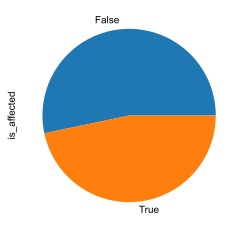

In [26]:
print(df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().value_counts())
df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().value_counts().plot.pie()

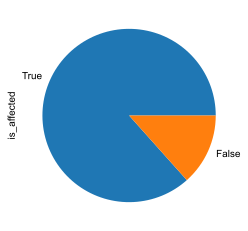

In [46]:
rnd.loc[rnd['is_DBD'], :].groupby('alt_iso')['is_affected'].any().value_counts().plot.pie()

Text(952, 3, 'real value')

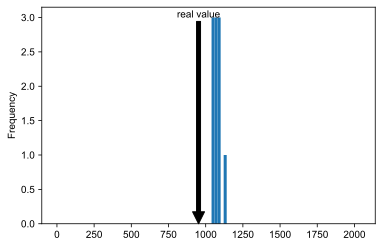

In [65]:
n = df.loc[df['is_DBD'], 'alt_iso'].nunique()
true_k = df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().sum()
rnd.loc[rnd['is_DBD'], :].groupby(['random_sample', 'alt_iso'])['is_affected'].any().sum(level=0).plot.hist(range=(0, n), bins=100)
plt.annotate(xy=(true_k, 0),
                s='real value',
                xytext=(true_k, 3),  # TODO: change y position
                arrowprops={'color': 'black'},
                ha='center')

In [7]:
%%time
df_null = pd.concat([g.null_fraction_per_aa_feature(g.orfs[0].name) for g in tfs.values()])
df['null_fraction_affected'] = df_null['null_fraction_affected']

CPU times: user 3min 25s, sys: 2.24 s, total: 3min 28s
Wall time: 3min 37s


In [28]:
(df['gene'].nunique(), df.loc[df['is_DBD'], 'gene'].nunique())

(946, 788)

In [9]:
from poibin import PoiBin

952 2038 2.1802977652642392e-13


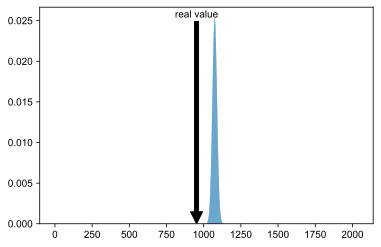

In [29]:
def domain_disruption_significance_plot(df, ax=None):
    if ax is None:
        ax = plt.gca()
    n = df['alt_iso'].nunique()
    true_k = df.groupby('alt_iso')['is_affected'].any().sum()

    def prob_or(probabilities):
        return 1 - (np.prod(1 - probabilities))

    null_p = df.groupby('alt_iso')['null_fraction_affected'].apply(prob_or).values
    pval = PoiBin(null_p).cdf(true_k)
    pmf = PoiBin(null_p).pmf(range(n))
    ax.bar(x=range(n),
            height=pmf,
            width=1.)
    ax.annotate(xy=(true_k, 0),
                s='real value',
                xytext=(true_k, max(pmf)),
                arrowprops={'color': 'black'},
                ha='center')
    print(true_k, n, pval)

domain_disruption_significance_plot(df.loc[df['is_DBD'], :])

495 900 2.3274485321861442e-11


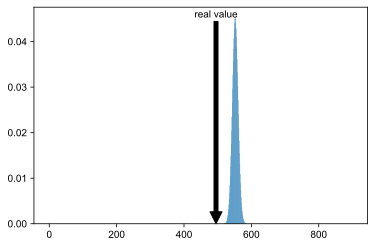

In [30]:
domain_disruption_significance_plot(df.loc[df['accession'].str.startswith('C2H2_ZF_array'), :])

91 203 0.4139749546644529
9 17 0.08050011948199243
13 28 0.23274890279759586
17 58 0.008940415379316186
16 34 0.895011212008634
3 16 0.0002193410911062688
10 44 0.00013663877410485152
61 166 0.0017987544403838842
12 35 0.4202162965431366
8 32 0.0885485717808788
6 22 0.0026951980850650793
17 42 0.48327223746241077
14 50 0.5481787495606276
45 123 0.020109447409961026
42 72 0.7324498610349226
9 32 0.0007931720916683707
18 32 0.8871870819161093
35 130 0.06185298013411143


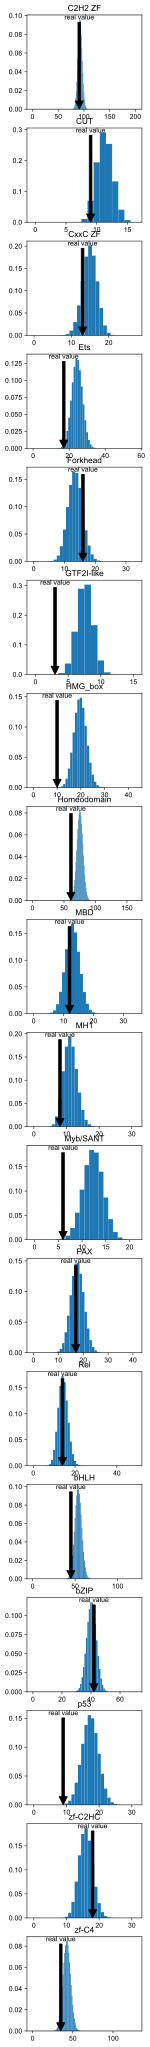

In [19]:
above_size_cutoff = (dbd['num_genes'] >= 30)
n_dbd = above_size_cutoff.sum()
fig, axes = plt.subplots(n_dbd, 1)
fig.set_size_inches(3, 3 * n_dbd)
for (_i, row), ax in zip(dbd.loc[above_size_cutoff].iterrows(), axes):
    ax.set_title(row['dbd'])
    domain_disruption_significance_plot(df.loc[df['accession'] == row['pfam'], :],
                                        ax=ax)

217 516 4.3632881257193133e-14


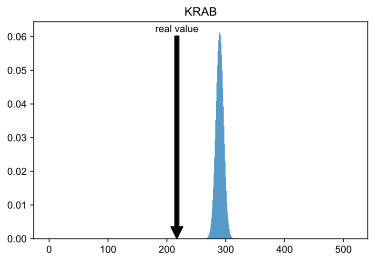

In [20]:
fig, ax = plt.subplots(1, 1)
ax.set_title('KRAB')
domain_disruption_significance_plot(df.loc[df['accession'] == 'PF01352', :],
                                    ax=ax)

6 30 0.08061308122817668


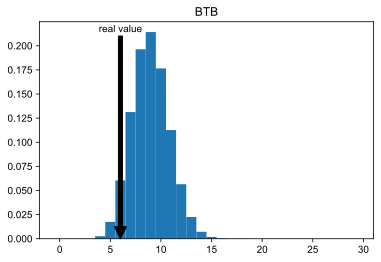

In [21]:
fig, ax = plt.subplots(1, 1)
ax.set_title('BTB')
domain_disruption_significance_plot(df.loc[df['accession'] == 'PF00651', :],
                                    ax=ax)

In [32]:
df.head()

,gene,ref_iso,alt_iso,accession,deletion,insertion,frameshift,length,is_DBD,is_affected,null_fraction_affected
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,0,0,0,22,True,False,0.032695
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,0,0,0,22,True,False,0.098884
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,0,0,0,22,True,False,0.117225
3,PRDM16,PRDM16-201,PRDM16-203,C2H2_ZF_array_6,0,0,0,164,True,False,0.039568
4,PRDM16,PRDM16-201,PRDM16-206,C2H2_ZF_array_6,0,0,0,164,True,False,0.223022


217 516 4.3632881257193133e-14
270 475 6.47217536183832e-14
154 259 3.566634834695215e-14
94 185 0.6446206085791074
65 130 0.540114064178459
27 73 0.0001370766428581122
45 81 0.98524448811746
47 72 3.767690967623473e-06
38 59 0.0010096186282257137
6 30 0.08061308122817668


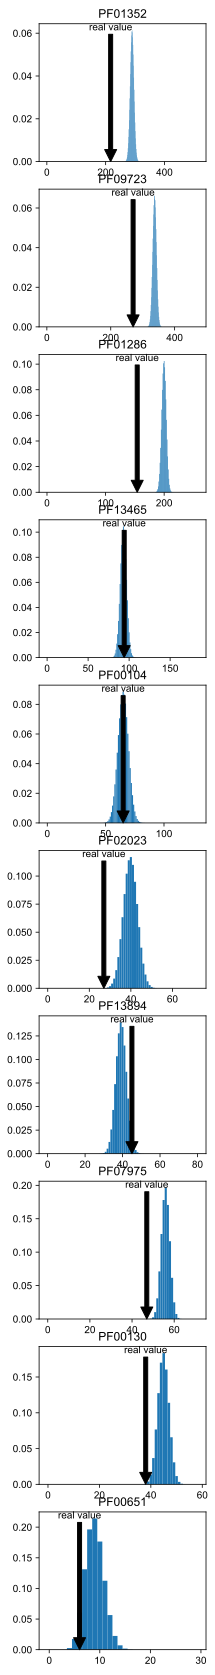

In [38]:
fig, axes = plt.subplots(10, 1)
fig.set_size_inches(3, 30)
for pfam_ac, ax in zip(df.loc[~df['is_DBD'], :].groupby('accession')['gene'].nunique().sort_values(ascending=False).head(10).index, axes):
    ax.set_title(pfam_ac)
    domain_disruption_significance_plot(df.loc[df['accession'] == pfam_ac, :],
                                    ax=ax)